In [4]:
import os
from datetime import datetime
import numpy as np
import pandas as pd
from scipy.special import expit
import ampligraph
from ampligraph.latent_features import RandomBaseline, TransE, ComplEx, HolE, DistMult
from ampligraph.datasets import load_fb13, load_wn11, load_yago3_10
from ampligraph.utils import save_model, restore_model


SAVE_MODEL_PATH = datetime.now().strftime('%m-%d_%H-%M-%S')
LOAD_MODEL_PATH = ''
os.mkdir(SAVE_MODEL_PATH)
print('made model directory:', SAVE_MODEL_PATH)


import calmetrics
import calmethods
import calutils


class DatasetWrapper:
    def __init__(self, name, X_train, X_valid, y_valid, X_test, y_test):
        self.name = name
        self.X_train = X_train
        self.X_valid = X_valid
        self.y_valid = y_valid
        self.X_test = X_test
        self.y_test = y_test
        
class UncalCalibtator:
    def __init__(self):
        self.name = 'UncalCalibtator'       
    def fit(self, scores, y):
        pass
    def predict_proba(self, scores):
        return scores

from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from betacal import BetaCalibration

def oneD_to_twoD(array):
    if len(array.shape) == 1: # 1D array
        array = array.reshape(-1, 1) # convert to 2D array
    return array

class PlattCalibtator:
    def __name__(self):
        return 'PlattCalibrator'
    def __init__(self):
        self.name = 'PlattCalibrator'
        self._calibrator = LogisticRegression()    
    def fit(self, uncal_probs, y):
        uncal_probs = oneD_to_twoD(uncal_probs)
        self._calibrator.fit(uncal_probs, y)
        return self
    def predict_proba(self, uncal_probs):
        uncal_probs = oneD_to_twoD(uncal_probs)
        return self._calibrator.predict_proba(uncal_probs)[:, 1]
    
class IsotonicCalibrator:
    def __init__(self):
        self.name = 'IsotonicCalibrator'
        self._calibrator = IsotonicRegression(y_min=0, y_max=1, out_of_bounds='clip')
    def fit(self, scores, y):
        self._calibrator.fit(scores, y)
        return self
    def predict_proba(self, scores):
        return self._calibrator.predict(scores)
    

class HistogramBinningCalibtator:
    """
    Histogram Binning as a calibration method. The bins are divided into equal lengths.
    
    The class contains two methods:
        - fit(probs, true), that should be used with validation data to train the calibration model.
        - predict(probs), this method is used to calibrate the confidences.
    """
    
    def __init__(self, M=15):
        """
        M (int): the number of equal-length bins used
        """
        self.name = 'HistogramBinningCalibtator'
        self.bin_size = 1./M  # Calculate bin size
        self.conf = []  # Initiate confidence list
        self.upper_bounds = np.arange(self.bin_size, 1+self.bin_size, self.bin_size)  # Set bin bounds for intervals
 
    def _get_conf(self, conf_thresh_lower, conf_thresh_upper, probs, true):
        """
        Inner method to calculate optimal confidence for certain probability range
        
        Params:
            - conf_thresh_lower (float): start of the interval (not included)
            - conf_thresh_upper (float): end of the interval (included)
            - probs : list of probabilities.
            - true : list with true labels, where 1 is positive class and 0 is negative).
        """

        # Filter labels within probability range
        filtered = [x[0] for x in zip(true, probs) if x[1] > conf_thresh_lower and x[1] <= conf_thresh_upper]
        nr_elems = len(filtered)  # Number of elements in the list.

        if nr_elems < 1:
            return 0
        else:
            # In essence the confidence equals to the average accuracy of a bin
            conf = sum(filtered)/nr_elems  # Sums positive classes
            return conf  

    def fit(self, probs, true):
        """
        Fit the calibration model, finding optimal confidences for all the bins.
        
        Params:
            probs: probabilities of data
            true: true labels of data
        """

        conf = []

        # Got through intervals and add confidence to list
        for conf_thresh in self.upper_bounds:
            temp_conf = self._get_conf((conf_thresh - self.bin_size), conf_thresh, probs = probs, true = true)
            conf.append(temp_conf)

        self.conf = conf

    # Fit based on predicted confidence
    def predict_proba(self, probs):
        """
        Calibrate the confidences
        
        Param:
            probs: probabilities of the data (shape [samples, classes])
            
        Returns:
            Calibrated probabilities (shape [samples, classes])
        """
        # Go through all the probs and check what confidence is suitable for it.
        for i, prob in enumerate(probs):
            idx = np.searchsorted(self.upper_bounds, prob)
            probs[i] = self.conf[idx]

        return probs
    
class BetaCalibtator:
    def __name__(self):
        return 'BetaCalibrator'
    def __init__(self):
        self.name = 'BetaCalibrator'
        self._calibrator = BetaCalibration()
    def fit(self, uncal_probs, y):
        self._calibrator.fit(uncal_probs, y)
        return self
    def predict_proba(self, uncal_probs):
        return self._calibrator.predict(uncal_probs)

    

        
def load_models() -> list:
    randm = RandomBaseline()
    transE = TransE(verbose=True)
    complEx = ComplEx(verbose=True)
    distMult = DistMult(verbose=True)
    hoLE = HolE(verbose=True)
    return [randm, transE, complEx, distMult, hoLE]
    
    
def load_yago39():
    data = {}
    with open('yago39/train_triple2id.txt', 'r') as f:
        lines = f.readlines()
        data['train'] = np.array([line.strip().split() for line in lines[1:]])
    train_entities = set(data['train'][:, 0]).union(set(data['train'][:, 2]))
    print(len(train_entities))
    with open('yago39/valid_triple2id_positive.txt', 'r') as f:
        lines = f.readlines()
        tmp = []
        for line in lines[1:]:
            triple = line.strip().split()
            if (triple[0] in train_entities) and (triple[2] in train_entities):
                tmp.append(triple)
        data['valid'] = np.array(tmp)
        data['valid_labels'] = np.ones(len(tmp))
    with open('yago39/valid_triple2id_negative.txt', 'r') as f:
        lines = f.readlines()
        tmp = []
        for line in lines[1:]:
            triple = line.strip().split()
            if (triple[0] in train_entities) and (triple[2] in train_entities):
                tmp.append(triple)
        data['valid'] = np.concatenate([data['valid'], np.array(tmp)])
        data['valid_labels'] = np.concatenate([data['valid_labels'], np.zeros(len(tmp))])
    with open('yago39/test_triple2id_positive.txt', 'r') as f:
        lines = f.readlines()
        tmp = []
        for line in lines[1:]:
            triple = line.strip().split()
            if (triple[0] in train_entities) and (triple[2] in train_entities):
                tmp.append(triple)
        data['test'] = np.array(tmp)
        data['test_labels'] = np.ones(len(tmp))
    with open('yago39/test_triple2id_negative.txt', 'r') as f:
        lines = f.readlines()
        tmp = []
        for line in lines[1:]:
            triple = line.strip().split()
            if (triple[0] in train_entities) and (triple[2] in train_entities):
                tmp.append(triple)
        data['test'] = np.concatenate([data['test'], np.array(tmp)])
        data['test_labels'] = np.concatenate([data['test_labels'], np.zeros(len(tmp))])
    valid_entities = set(data['valid'][:, 0]).union(set(data['valid'][:, 2]))
    test_entities = set(data['test'][:, 0]).union(set(data['test'][:, 2]))
    print(len(valid_entities - train_entities))
    print(len(test_entities - train_entities))
    return data

def load_datasets() -> list:
    tmp = load_fb13()
    fb13 = DatasetWrapper('FB13k', tmp['train'], 
                          tmp['valid'], 
                          tmp['valid_labels'].astype(np.int32), 
                          tmp['test'], 
                          tmp['test_labels'].astype(np.int32))
    
    tmp = load_wn11()
    wn11 = DatasetWrapper('WN11', tmp['train'], 
                          tmp['valid'], 
                          tmp['valid_labels'].astype(np.int32), 
                          tmp['test'], 
                          tmp['test_labels'].astype(np.int32))
    
    tmp = load_yago39()
    yago39 = DatasetWrapper('YAGO39', tmp['train'], 
                          tmp['valid'], 
                          tmp['valid_labels'].astype(np.int32), 
                          tmp['test'], 
                          tmp['test_labels'].astype(np.int32))
    
    return [fb13, wn11, yago39]

def load_calibrators() -> list:
    uncal = UncalCalibtator()
    platt = PlattCalibtator()
    isot = IsotonicCalibrator()
    histbin = HistogramBinningCalibtator()
    beta = BetaCalibtator()
    return [uncal, platt, beta, isot, histbin]

def load_metrics() -> list:
    return [
        calmetrics.brier_score,
        calmetrics.negative_log_loss,
        calmetrics.ks_error
    ]

    
def train_and_eval(model, dataset, calibrators, func_metrics):
    # train model with X_train
    print(f'training model {model.__class__.__name__} for dataset {dataset.name} ...')
    model.fit(dataset.X_train)
    save_model(model, model_name_path=os.path.join(SAVE_MODEL_PATH, f'{model.__class__.__name__}-{dataset.name}.pkl'))
    # train calibrators 
    scores_valid = expit(model.predict(dataset.X_valid))
    scores_test = expit(model.predict(dataset.X_test))
    for calibrator in calibrators:
        print(f'training calibrator {calibrator.name} for  model {model.__class__.__name__} and dataset {dataset.name} ...')
        calibrator.fit(scores_valid, dataset.y_valid)
        probs_test = calibrator.predict_proba(scores_test)
        for func_metric in func_metrics:
            print(func_metric.__name__, ":", func_metric(dataset.y_test, probs_test))
    
def main():
    
    models = load_models()
    datasets = load_datasets()
    calibrators = load_calibrators()
    func_metrics = load_metrics()
    
    from copy import deepcopy
    for model in models:
        for dataset in datasets:
            try:
                blank_model = deepcopy(model)
                blank_calibrators = deepcopy(calibrators)
                train_and_eval(blank_model, dataset, blank_calibrators, func_metrics)
                print('\n-------------------------------------\n')
            except Exception as e:
                print('Error:', e)
                          

made model directory: 10-23_21-49-00


In [24]:
main()

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.
32079
0
0
training model RandomBaseline for dataset FB13k ...
training calibrator UncalCalibtator for  model RandomBaseline and dataset FB13k ...
brier_score : 0.2684975284759183
negative_log_loss : 0.7328676969634227
ks_error : 0.12044093177066617
training calibrator PlattCalibrator for  model RandomBaseline and dataset FB13k ...
brier_score : 0.24999518938895152
negative_log_loss : 0.6931375648878926
ks_error : 0.0020835739842205436
training calibrator BetaCalibrator for  model RandomBaseline and dataset FB13k ...
brier_score : 0.250000257510694
negative_log_loss : 0.6931477050373447
ks_error : 0.0024444005960202464
training calibrator IsotonicCalibrator for  model RandomBaseline and dataset FB13k ...
brier_score : 0.2501517026620063
negative_log_loss : 0.6935005047487761
ks_error : 0.0039150408361927624
training calib

Average TransE Loss:   1.087920: 100%|████████████████████████████████████████████| 100/100 [17:21<00:00, 10.41s/epoch]


training calibrator UncalCalibtator for  model TransE and dataset FB13k ...
brier_score : 0.24203960267948016
negative_log_loss : 0.6761335508856489
ks_error : 0.09865471556438632
training calibrator PlattCalibrator for  model TransE and dataset FB13k ...
brier_score : 0.21235960241267351
negative_log_loss : 0.6165714271049767
ks_error : 0.028312188456209808
training calibrator BetaCalibrator for  model TransE and dataset FB13k ...
brier_score : 0.20924600244971653
negative_log_loss : 0.6099175821122884
ks_error : 0.01862409469581283
training calibrator IsotonicCalibrator for  model TransE and dataset FB13k ...
brier_score : 0.20591321375918967
negative_log_loss : nan
ks_error : 0.004375228652981428
training calibrator HistogramBinningCalibtator for  model TransE and dataset FB13k ...
brier_score : 0.21607712151624078
negative_log_loss : 0.6204131372482057
ks_error : 0.0033984795129863854

-------------------------------------

training model TransE for dataset WN11 ...


Average TransE Loss:   0.961199: 100%|████████████████████████████████████████████| 100/100 [07:28<00:00,  4.48s/epoch]


training calibrator UncalCalibtator for  model TransE and dataset WN11 ...
brier_score : 0.24231852583366786
negative_log_loss : 0.7020343918818709
ks_error : 0.3103566750253407
training calibrator PlattCalibrator for  model TransE and dataset WN11 ...
brier_score : 0.09035140122217608
negative_log_loss : 0.30856702474268194
ks_error : 0.024178158455601114
training calibrator BetaCalibrator for  model TransE and dataset WN11 ...
brier_score : 0.09010570081884385
negative_log_loss : 0.3090112773520534
ks_error : 0.018783613764751874
training calibrator IsotonicCalibrator for  model TransE and dataset WN11 ...
brier_score : 0.08738154675067811
negative_log_loss : nan
ks_error : 0.004423032990856897
training calibrator HistogramBinningCalibtator for  model TransE and dataset WN11 ...
brier_score : 0.08826893223426378
negative_log_loss : nan
ks_error : 0.005896101671796661

-------------------------------------

training model TransE for dataset YAGO39 ...


Average TransE Loss:   0.908316: 100%|████████████████████████████████████████████| 100/100 [12:12<00:00,  7.33s/epoch]


ERROR - Input triples include one or more concepts not present in the training set. Please filter all concepts in X that do not occur in the training test (set filter_unseen=True in evaluate_performance) or retrain the model on a training set that includes all the desired concept types.
Error: Input triples include one or more concepts not present in the training set. Please filter all concepts in X that do not occur in the training test (set filter_unseen=True in evaluate_performance) or retrain the model on a training set that includes all the desired concept types.
training model ComplEx for dataset FB13k ...


Average ComplEx Loss:   0.191861: 100%|███████████████████████████████████████████| 100/100 [39:54<00:00, 23.94s/epoch]


training calibrator UncalCalibtator for  model ComplEx and dataset FB13k ...
brier_score : 0.4100634233743666
negative_log_loss : 2.2903791421950426
ks_error : 0.4220453333087641
training calibrator PlattCalibrator for  model ComplEx and dataset FB13k ...
brier_score : 0.2211132503262728
negative_log_loss : 0.6332010154100297
ks_error : 0.05315326683122401
training calibrator BetaCalibrator for  model ComplEx and dataset FB13k ...
brier_score : 0.22553111302435333
negative_log_loss : 0.6423298893077655
ks_error : 0.05031979974985035
training calibrator IsotonicCalibrator for  model ComplEx and dataset FB13k ...
brier_score : 0.20521510205128568
negative_log_loss : nan
ks_error : 0.004743598488195722
training calibrator HistogramBinningCalibtator for  model ComplEx and dataset FB13k ...
brier_score : 0.22315979532144595
negative_log_loss : 0.6330021293015236
ks_error : 0.002960665826148068

-------------------------------------

training model ComplEx for dataset WN11 ...


Average ComplEx Loss:   0.008186: 100%|███████████████████████████████████████████| 100/100 [16:55<00:00, 10.16s/epoch]


training calibrator UncalCalibtator for  model ComplEx and dataset WN11 ...
brier_score : 0.4198317154303649
negative_log_loss : 2.8128136065043825
ks_error : 0.43282180679358045
training calibrator PlattCalibrator for  model ComplEx and dataset WN11 ...
brier_score : 0.2259155996626409
negative_log_loss : 0.6357144121708104
ks_error : 0.016950530064222202
training calibrator BetaCalibrator for  model ComplEx and dataset WN11 ...
brier_score : 0.22720049101997886
negative_log_loss : 0.6444555697363239
ks_error : 0.015109823072445738
training calibrator IsotonicCalibrator for  model ComplEx and dataset WN11 ...
brier_score : 0.22403506490499536
negative_log_loss : 0.6308302582142064
ks_error : 0.0025818758313999185
training calibrator HistogramBinningCalibtator for  model ComplEx and dataset WN11 ...
brier_score : 0.22619791611170936
negative_log_loss : nan
ks_error : 0.0025793498970464457

-------------------------------------

training model ComplEx for dataset YAGO39 ...


Average ComplEx Loss:   0.067053: 100%|███████████████████████████████████████████| 100/100 [32:33<00:00, 19.53s/epoch]


ERROR - Input triples include one or more concepts not present in the training set. Please filter all concepts in X that do not occur in the training test (set filter_unseen=True in evaluate_performance) or retrain the model on a training set that includes all the desired concept types.
Error: Input triples include one or more concepts not present in the training set. Please filter all concepts in X that do not occur in the training test (set filter_unseen=True in evaluate_performance) or retrain the model on a training set that includes all the desired concept types.
training model DistMult for dataset FB13k ...


Average DistMult Loss:   0.213265: 100%|██████████████████████████████████████████| 100/100 [18:12<00:00, 10.93s/epoch]


training calibrator UncalCalibtator for  model DistMult and dataset FB13k ...
brier_score : 0.3836241201356534
negative_log_loss : 2.01791222113999
ks_error : 0.3802549206957374
training calibrator PlattCalibrator for  model DistMult and dataset FB13k ...
brier_score : 0.22967954497012896
negative_log_loss : 0.6465461397346891
ks_error : 0.023676875749636228
training calibrator BetaCalibrator for  model DistMult and dataset FB13k ...
brier_score : 0.23052820336624266
negative_log_loss : 0.6495942738889137
ks_error : 0.031198408051960336
training calibrator IsotonicCalibrator for  model DistMult and dataset FB13k ...
brier_score : 0.22520472193937432
negative_log_loss : nan
ks_error : 0.0034514320965623457
training calibrator HistogramBinningCalibtator for  model DistMult and dataset FB13k ...
brier_score : 0.2288702236083335
negative_log_loss : 0.6448424065555999
ks_error : 0.002858426204001785

-------------------------------------

training model DistMult for dataset WN11 ...


Average DistMult Loss:   0.028390: 100%|██████████████████████████████████████████| 100/100 [07:53<00:00,  4.73s/epoch]


training calibrator UncalCalibtator for  model DistMult and dataset WN11 ...
brier_score : 0.3922234910240632
negative_log_loss : 2.0934008919659868
ks_error : 0.40822910323193096
training calibrator PlattCalibrator for  model DistMult and dataset WN11 ...
brier_score : 0.2184343561167011
negative_log_loss : 0.6179961966044359
ks_error : 0.014669746067275335
training calibrator BetaCalibrator for  model DistMult and dataset WN11 ...
brier_score : 0.218962545442956
negative_log_loss : 0.6260590679025031
ks_error : 0.01555612355144076
training calibrator IsotonicCalibrator for  model DistMult and dataset WN11 ...
brier_score : 0.217461666409126
negative_log_loss : nan
ks_error : 0.003814560609893214
training calibrator HistogramBinningCalibtator for  model DistMult and dataset WN11 ...
brier_score : 0.2185885698941902
negative_log_loss : nan
ks_error : 0.00350753810397747

-------------------------------------

training model DistMult for dataset YAGO39 ...


Average DistMult Loss:   0.099399: 100%|██████████████████████████████████████████| 100/100 [12:18<00:00,  7.39s/epoch]


ERROR - Input triples include one or more concepts not present in the training set. Please filter all concepts in X that do not occur in the training test (set filter_unseen=True in evaluate_performance) or retrain the model on a training set that includes all the desired concept types.
Error: Input triples include one or more concepts not present in the training set. Please filter all concepts in X that do not occur in the training test (set filter_unseen=True in evaluate_performance) or retrain the model on a training set that includes all the desired concept types.
training model HolE for dataset FB13k ...


Average HolE Loss:   0.725869: 100%|██████████████████████████████████████████████| 100/100 [39:35<00:00, 23.75s/epoch]


training calibrator UncalCalibtator for  model HolE and dataset FB13k ...
brier_score : 0.31094050467705275
negative_log_loss : 0.9264620093097848
ks_error : 0.16975161457582166
training calibrator PlattCalibrator for  model HolE and dataset FB13k ...
brier_score : 0.2480769873583764
negative_log_loss : 0.689249909530124
ks_error : 0.06293461663932887
training calibrator BetaCalibrator for  model HolE and dataset FB13k ...
brier_score : 0.2348090436520992
negative_log_loss : 0.65813781970812
ks_error : 0.07901435864140946
training calibrator IsotonicCalibrator for  model HolE and dataset FB13k ...
brier_score : 0.21655216019360604
negative_log_loss : nan
ks_error : 0.0026453995551947163
training calibrator HistogramBinningCalibtator for  model HolE and dataset FB13k ...
brier_score : 0.17979725676797267
negative_log_loss : 0.5369826244657645
ks_error : 0.005258060242059603

-------------------------------------

training model HolE for dataset WN11 ...


Average HolE Loss:   0.723459: 100%|██████████████████████████████████████████████| 100/100 [16:52<00:00, 10.13s/epoch]


training calibrator UncalCalibtator for  model HolE and dataset WN11 ...
brier_score : 0.2083094776375876
negative_log_loss : 0.593846216900172
ks_error : 0.09535406240893779
training calibrator PlattCalibrator for  model HolE and dataset WN11 ...
brier_score : 0.1986524832227268
negative_log_loss : 0.5762679173345209
ks_error : 0.022063785493188826
training calibrator BetaCalibrator for  model HolE and dataset WN11 ...
brier_score : 0.19505010721568744
negative_log_loss : 0.5632258837783274
ks_error : 0.013829448549426693
training calibrator IsotonicCalibrator for  model HolE and dataset WN11 ...
brier_score : 0.19226344814198223
negative_log_loss : 0.5528811532586023
ks_error : 0.0032608614020646076
training calibrator HistogramBinningCalibtator for  model HolE and dataset WN11 ...
brier_score : 0.19288603268089713
negative_log_loss : nan
ks_error : 0.005407610596418033

-------------------------------------

training model HolE for dataset YAGO39 ...


Average HolE Loss:   0.330359: 100%|██████████████████████████████████████████████| 100/100 [31:43<00:00, 19.03s/epoch]


ERROR - Input triples include one or more concepts not present in the training set. Please filter all concepts in X that do not occur in the training test (set filter_unseen=True in evaluate_performance) or retrain the model on a training set that includes all the desired concept types.
Error: Input triples include one or more concepts not present in the training set. Please filter all concepts in X that do not occur in the training test (set filter_unseen=True in evaluate_performance) or retrain the model on a training set that includes all the desired concept types.


In [5]:
from copy import deepcopy
from calmetrics import negative_log_loss

def eval_model(model, dataset, calibrators, func_metrics):
    df = pd.DataFrame(0, columns=[i.name[:-10] for i in calibrators], index=[i.__name__ for i in func_metrics])

    scores_valid = expit(model.predict(dataset.X_valid))
    scores_test = expit(model.predict(dataset.X_test))
    for calibrator in calibrators:
        print(f'training calibrator {calibrator.name} for  model {model.__class__.__name__} and dataset {dataset.name} ...')
        calibrator.fit(scores_valid, dataset.y_valid)
        probs_test = calibrator.predict_proba(scores_test)
#         print(np.max(probs_test))
        for func_metric in func_metrics:
            print('{:<20}: {:6f}'.format(func_metric.__name__, func_metric(dataset.y_test, probs_test)))
            df.loc[func_metric.__name__, calibrator.name[:-10]] = func_metric(dataset.y_test, probs_test)
    print(df)
    print('\n----------------------------------\n')

datasets = load_datasets()
calibrators = load_calibrators()
func_metrics = load_metrics()
model_names = os.listdir('10-14_18-38-45')
models = {}
for name in model_names:
    model = restore_model(os.path.join('10-14_18-38-45',name))
    models[name] = model


blank_calibrators = deepcopy(calibrators)
eval_model(models['RandomBaseline-FB13k.pkl'], datasets[0], blank_calibrators, func_metrics)
blank_calibrators = deepcopy(calibrators)
eval_model(models['RandomBaseline-WN11.pkl'], datasets[1], blank_calibrators, func_metrics)

blank_calibrators = deepcopy(calibrators)
eval_model(models['TransE-FB13k.pkl'], datasets[0], blank_calibrators, func_metrics)
blank_calibrators = deepcopy(calibrators)
eval_model(models['TransE-WN11.pkl'], datasets[1], blank_calibrators, func_metrics)

blank_calibrators = deepcopy(calibrators)
eval_model(models['ComplEx-FB13k.pkl'], datasets[0], blank_calibrators, func_metrics)
blank_calibrators = deepcopy(calibrators)
eval_model(models['ComplEx-WN11.pkl'], datasets[1], blank_calibrators, func_metrics)

blank_calibrators = deepcopy(calibrators)
eval_model(models['DistMult-FB13k.pkl'], datasets[0], blank_calibrators, func_metrics)
blank_calibrators = deepcopy(calibrators)
eval_model(models['DistMult-WN11.pkl'], datasets[1], blank_calibrators, func_metrics)

blank_calibrators = deepcopy(calibrators)
eval_model(models['HolE-FB13k.pkl'], datasets[0], blank_calibrators, func_metrics)
blank_calibrators = deepcopy(calibrators)
eval_model(models['HolE-WN11.pkl'], datasets[1], blank_calibrators, func_metrics)

blank_calibrators = deepcopy(calibrators)
eval_model(models['TransE-FB13k.pkl'], datasets[0], blank_calibrators, func_metrics)
blank_calibrators = deepcopy(calibrators)
eval_model(models['TransE-WN11.pkl'], datasets[1], blank_calibrators, func_metrics)

32079
0
0
WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.
WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.
WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.
training calibrator UncalCalibtator for  model RandomBaseline and dataset FB13k ...
brier_score         : 0.268797
negative_log_loss   : 0.733519
ks_error            : 0.119869
training calibrator PlattCalibrator for  model RandomBaseline and dataset FB13k ...
brier_score         : 0.250000
negative_log_loss   : 0.693147
ks_error            : 0.001434
training calibrator BetaCalibrator for  model RandomBaseline and dataset FB13k ...
brier_score         : 0.250000
negative_log_loss 

brier_score         : 0.228870
negative_log_loss   : 0.644842
ks_error            : 0.002858
                      Uncal     Platt      Beta  Isotonic  HistogramBinning
brier_score        0.383624  0.229680  0.230528  0.225205          0.228870
negative_log_loss  2.012092  0.646546  0.649594  0.637874          0.644842
ks_error           0.380255  0.023677  0.031198  0.003451          0.002858

----------------------------------

training calibrator UncalCalibtator for  model DistMult and dataset WN11 ...
brier_score         : 0.392223
negative_log_loss   : 2.093234
ks_error            : 0.408229
training calibrator PlattCalibrator for  model DistMult and dataset WN11 ...
brier_score         : 0.218434
negative_log_loss   : 0.617996
ks_error            : 0.014670
training calibrator BetaCalibrator for  model DistMult and dataset WN11 ...
brier_score         : 0.218963
negative_log_loss   : 0.622969
ks_error            : 0.015556
training calibrator IsotonicCalibrator for  model DistMul

In [ ]:
model = models['TransE-WN11.pkl']
dataset = datasets[1]
scores_valid = model.predict(dataset.X_valid)
scores_test = model.predict(dataset.X_test)

print(scores_valid.shape,dataset.y_valid.shape, scores_test.shape)

bc = BetaCalibration()
bc.fit(scores_valid, dataset.y_valid)

bc.calibrator_

# bc.predict(scores_test)



In [ ]:
print(bc.calibrator_.lr_.coef_, bc.calibrator_.lr_.intercept_)

In [ ]:
from sklearn.utils import indexable, column_or_1d
from scipy.optimize import minimize_scalar
from sklearn.linear_model import LogisticRegression

def _beta_calibration(df, y, sample_weight=None):
#     warnings.filterwarnings("ignore")

    df = column_or_1d(df).reshape(-1, 1)
    eps = np.finfo(df.dtype).eps
    df = np.clip(df, eps, 1-eps)
    y = column_or_1d(y)

    x = np.hstack((df, 1. - df))
    x = np.log(x)
    x[:, 1] *= -1

    lr = LogisticRegression(C=99999999999)
    lr.fit(x, y, sample_weight)
    coefs = lr.coef_[0]

    if coefs[0] < 0:
        x = x[:, 1].reshape(-1, 1)
        lr = LogisticRegression(C=99999999999)
        lr.fit(x, y, sample_weight)
        coefs = lr.coef_[0]
        a = 0
        b = coefs[0]
    elif coefs[1] < 0:
        x = x[:, 0].reshape(-1, 1)
        lr = LogisticRegression(C=99999999999)
        lr.fit(x, y, sample_weight)
        coefs = lr.coef_[0]
        a = coefs[0]
        b = 0
    else:
        a = coefs[0]
        b = coefs[1]
    inter = lr.intercept_[0]

    m = minimize_scalar(lambda mh: np.abs(b*np.log(1.-mh)-a*np.log(mh)-inter),
                        bounds=[0, 1], method='Bounded').x
    map = [a, b, m]
    return map, lr

In [ ]:
mp, lr = _beta_calibration(scores_valid, dataset.y_valid)

In [ ]:
!pip install netcal

In [ ]:
from netcal.binning import HistogramBinning
from scipy.special import expit
hb = HistogramBinning()
hb.fit(expit(scores_valid), dataset.y_valid)
hb.transform(expit(scores_test))

In [6]:

new_transE = TransE()
calibrators = load_calibrators()
func_metrics = load_metrics()
train_and_eval(new_transE, datasets[0], calibrators, func_metrics)

training model TransE for dataset FB13k ...
training calibrator UncalCalibtator for  model TransE and dataset FB13k ...
brier_score : 0.24201365119664545
negative_log_loss : 0.6762264953464
ks_error : 0.09886559679760165
training calibrator PlattCalibrator for  model TransE and dataset FB13k ...
brier_score : 0.21211194565765532
negative_log_loss : 0.6162166563810462
ks_error : 0.027720358046130822
training calibrator BetaCalibrator for  model TransE and dataset FB13k ...
brier_score : 0.20904371355956375
negative_log_loss : 0.6097185854879732
ks_error : 0.016289827732570206
training calibrator IsotonicCalibrator for  model TransE and dataset FB13k ...
brier_score : 0.2063253658975446
negative_log_loss : 0.6006230134639148
ks_error : 0.004463001221704704
training calibrator HistogramBinningCalibtator for  model TransE and dataset FB13k ...
brier_score : 0.2153937272397758
negative_log_loss : 0.6188629822332721
ks_error : 0.004041396131679059


Average ComplEx Loss:   0.171940: 100%|███████████████████████████████████████████| 100/100 [05:18<00:00,  3.19s/epoch]


In [3]:
model.predict(dat)

array([2.8861175, 6.958498 , 7.050413 , ..., 5.903042 , 4.6821303,
       7.8753867], dtype=float32)

In [127]:
import numpy as np
import tensorflow as tf
import pandas as pd

from scipy.special import expit
from ampligraph.latent_features import ComplEx, TransE, DistMult, HolE
from ampligraph.evaluation import generate_corruptions_for_fit, create_mappings, to_idx
from netcal.scaling import BetaCalibration 
from netcal.binning import IsotonicRegression, HistogramBinning
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
%matplotlib inline

In [134]:
def negative_sampling(dat, eta=1):
    '''
    Given a set of positive triples, perform negative sampling by corruption
    return a set of (X, y)
    '''
    rel_to_idx, ent_to_idx = create_mappings(dat)
    dat_id = to_idx(dat, ent_to_idx, rel_to_idx)
    dat2 = generate_corruptions_for_fit(dat_id, eta=eta)

    dat2_id = dat2.eval(session=tf.compat.v1.Session())
    X = np.concatenate([dat_id, dat2_id])
    y = np.concatenate([np.ones(len(dat_id)), np.zeros(len(dat2_id))])
    idx_to_rel = {v:k for k,v in rel_to_idx.items()}
    idx_to_ent = {v:k for k,v in ent_to_idx.items()}
    C = []
    for x in X:
        h, r, t = x
        C.append([idx_to_ent[h], idx_to_rel[r], idx_to_ent[t]])

    return np.array(C), y

def filter_unseen(train, test, y_test):
    entities = set()
    relations = set()
    for x in train:
        h, r, t = x
        entities.add(h)
        relations.add(r)
        entities.add(t)
    filtered_triple = []
    filtered_y = []
    for i in range(len(test)):
        h, r, t = test[i]
        if (h in entities) and (t in entities) and (r in relations):
            filtered_triple.append([h, r, t])
            filtered_y.append(y_test[i])
    return np.array(filtered_triple), np.array(filtered_y)



In [144]:
with open('ontology_log_instance.ttl', 'r') as f:
    lines = np.array([i.strip().split(' ')[:3] for i in f.readlines()])
dat = []
for l in lines:
    if str(l[2]).startswith('<http'):
        dat.append(l)
dat = np.array(dat)
np.random.shuffle(dat)

X_train = dat[:int(len(dat)*0.7)]
X_rest = dat[int(len(dat)*0.7):]

X, y = negative_sampling(X_rest, eta=1)
X_cal, X_test, y_cal, y_test = train_test_split(X, y)

X_cal, y_cal = filter_unseen(X_train, X_cal, y_cal)
X_test, y_test = filter_unseen(X_train, X_test, y_test)

print(X_cal, y_cal)

[['<http://treat.net/onto.owl#alm_100001_248>'
  '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>'
  '<http://www.w3.org/2002/07/owl#NamedIndividual>']
 ['<http://treat.net/onto.owl#alm_100001_363>'
  '<http://treat.net/onto.owl#has_parameter>'
  '<http://treat.net/onto.owl#pod_15>']
 ['<http://treat.net/onto.owl#alm_5521_829>'
  '<http://treat.net/onto.owl#has_parameter>'
  '<http://treat.net/onto.owl#alarm_para_instance_1154>']
 ...
 ['<http://treat.net/onto.owl#alm_5521_428>'
  '<http://treat.net/onto.owl#has_property>'
  '<http://treat.net/onto.owl#alarm_type_6>']
 ['<http://treat.net/onto.owl#microservice_12>'
  '<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>'
  '<http://treat.net/onto.owl#Microservice>']
 ['<http://treat.net/onto.owl#alarm_para_instance_1747>'
  '<http://treat.net/onto.owl#has_parameter>'
  '<http://treat.net/onto.owl#alarm_para_instance_3026>']] [1. 0. 1. ... 0. 1. 0.]


In [151]:
model = ComplEx(verbose=True)
model.fit(X_train)

Average ComplEx Loss:   0.265538: 100%|███████████████████████████████████████████| 100/100 [02:49<00:00,  1.70s/epoch]


In [155]:
scores_cal = expit(model.predict(X_cal))
calibrator = IsotonicRegression()
calibrator.fit(scores_cal, y_cal)
scores_test = expit(model.predict(X_test))
proba_test = calibrator.transform(scores_test)

print(mean_squared_error(proba_test, y_test))
ece = ECE()
print(ece.measure(proba_test, y_test))

prob_triples = np.c_[(X_test, proba_test)]
df = pd.DataFrame(prob_triples,columns=['head', 'relation', 'tail', 'proba'])

0.15712680772841758
0.015924066096040586


,head,relation,tail,proba
0,<http://treat.net/onto.owl#alm_5521_790>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.14925373134328357
1,<http://treat.net/onto.owl#alm_5558>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://treat.net/onto.owl#alm_5521_661>,0.23404255319148937
2,<http://treat.net/onto.owl#alm_82013>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.21661468670258013
3,<http://treat.net/onto.owl#alm_100001_607>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://treat.net/onto.owl#alarm_para_instance...,0.22044728434504793
4,<http://treat.net/onto.owl#alarm_para_instance...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://www.w3.org/2002/07/owl#NamedIndividual>,0.7461257976298997
...,...,...,...,...
5311,<http://treat.net/onto.owl#alm_5521_331>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.7688066167782593
5312,<http://treat.net/onto.owl#alarm_para_instance...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://www.w3.org/2002/07/owl#NamedIndividual>,0.7209302325581395
5313,<http://treat.net/onto.owl#alm_100058_15648>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://treat.net/onto.owl#alarm_para_instance...,0.3649216161634274
5314,<http://treat.net/onto.owl#alm_100155_83>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alm_100001_539>,0.19881305637982197


In [157]:
df

,head,relation,tail,proba
0,<http://treat.net/onto.owl#alm_5521_790>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.14925373134328357
1,<http://treat.net/onto.owl#alm_5558>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://treat.net/onto.owl#alm_5521_661>,0.23404255319148937
2,<http://treat.net/onto.owl#alm_82013>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.21661468670258013
3,<http://treat.net/onto.owl#alm_100001_607>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://treat.net/onto.owl#alarm_para_instance...,0.22044728434504793
4,<http://treat.net/onto.owl#alarm_para_instance...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://www.w3.org/2002/07/owl#NamedIndividual>,0.7461257976298997
...,...,...,...,...
5311,<http://treat.net/onto.owl#alm_5521_331>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.7688066167782593
5312,<http://treat.net/onto.owl#alarm_para_instance...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://www.w3.org/2002/07/owl#NamedIndividual>,0.7209302325581395
5313,<http://treat.net/onto.owl#alm_100058_15648>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://treat.net/onto.owl#alarm_para_instance...,0.3649216161634274
5314,<http://treat.net/onto.owl#alm_100155_83>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alm_100001_539>,0.19881305637982197


<AxesSubplot:>

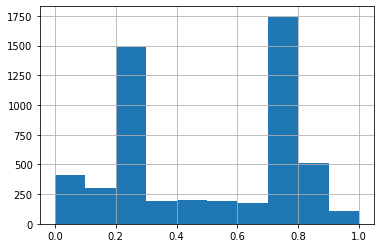

In [156]:
df['proba'].astype(float).hist()

In [159]:
scores_test = expit(model.predict(X_test[y_test==1]))
proba_test = calibrator.transform(scores_test)

print(mean_squared_error(proba_test, y_test[y_test==1]))
ece = ECE()
print(ece.measure(proba_test, y_test[y_test==1]))

prob_triples = np.c_[(X_test[y_test==1], proba_test)]
df = pd.DataFrame(prob_triples,columns=['head', 'relation', 'tail', 'proba'])

0.15048169148345975
0.31942629540009115


In [160]:
df

,head,relation,tail,proba
0,<http://treat.net/onto.owl#alm_5521_790>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.14925373134328357
1,<http://treat.net/onto.owl#alarm_para_instance...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://www.w3.org/2002/07/owl#NamedIndividual>,0.7461257976298997
2,<http://treat.net/onto.owl#cell_service_27>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://www.w3.org/2002/07/owl#NamedIndividual>,0.363395225464191
3,<http://treat.net/onto.owl#alm_100001_260>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.22044728434504793
4,<http://treat.net/onto.owl#alarm_para_instance...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://www.w3.org/2002/07/owl#NamedIndividual>,0.7461257976298997
...,...,...,...,...
2605,<http://treat.net/onto.owl#alm_5521_479>,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://www.w3.org/2002/07/owl#NamedIndividual>,0.7461257976298997
2606,<http://treat.net/onto.owl#alm_100058_15571>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.7688066167782593
2607,<http://treat.net/onto.owl#alm_5521_331>,<http://treat.net/onto.owl#has_parameter>,<http://treat.net/onto.owl#alarm_para_instance...,0.7688066167782593
2608,<http://treat.net/onto.owl#alarm_para_instance...,<http://www.w3.org/1999/02/22-rdf-syntax-ns#type>,<http://www.w3.org/2002/07/owl#NamedIndividual>,0.7209302325581395


<AxesSubplot:>

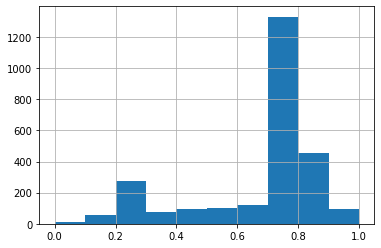

In [161]:
df['proba'].astype(float).hist()

In [163]:
X_dat = dat
y_dat = np.ones(len(X_dat))
scores_dat = expit(model.predict(X_dat))
proba_dat = calibrator.transform(scores_dat)

print(mean_squared_error(proba_test, y_dat))
ece = ECE()
print(ece.measure(proba_test, y_test[y_test==1]))

prob_triples = np.c_[(X_dat, proba_dat)]
df = pd.DataFrame(prob_triples,columns=['head', 'relation', 'tail', 'proba'])

ERROR - Input triples include one or more concepts not present in the training set. Please filter all concepts in X that do not occur in the training test (set filter_unseen=True in evaluate_performance) or retrain the model on a training set that includes all the desired concept types.


ValueError: Input triples include one or more concepts not present in the training set. Please filter all concepts in X that do not occur in the training test (set filter_unseen=True in evaluate_performance) or retrain the model on a training set that includes all the desired concept types.

<AxesSubplot:>

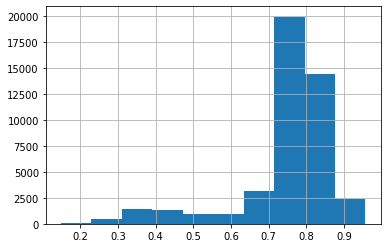

In [123]:
%matplotlib inline
df['proba'].astype(float).hist()

<AxesSubplot:>

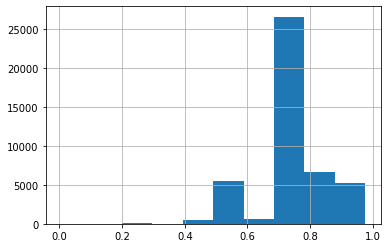

In [126]:
from netcal.binning import IsotonicRegression
isot = IsotonicRegression()
s = expit(model.predict(C))
isot.fit(s, y)
p = isot.transform(expit(model.predict(dat)))
prob_t = np.c_[(dat, p)]
df2 = pd.DataFrame(prob_t,columns=['head', 'relation', 'tail', 'proba'])
df2['proba'].astype(float).hist()

set()